### 🐱 Import libraries & packages

In [3]:
# import useful tools
import os
import numpy as np


# import visual tools
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# import CV, detection tools
import cv2
import dlib

### 🐱 Define constants

In [4]:
# define sticker types as constant numbers
CROWN = 1
HERO = 2
CAT = 3

# total number of pictures
PICS = 6

### 🐱 Load image files

In [5]:
file_path = "/aiffel/aiffel/camera_sticker/images/"

# Load sticker image files
stk_crown = cv2.cvtColor(cv2.imread(file_path + "king.png"), cv2.COLOR_BGR2RGB)
stk_hero = cv2.cvtColor(cv2.imread(file_path + "hero.png"), cv2.COLOR_BGR2RGB)
stk_cat = cv2.cvtColor(cv2.imread(file_path + "cat-whiskers.png"), cv2.COLOR_BGR2RGB)

# Load picture image files
images = {"bgr": [], "rgb": []}
for i in range (1, PICS+1):
    images["bgr"].append(cv2.imread(file_path + "image" + str(i) + ".png"))
    images["rgb"].append(cv2.cvtColor(images["bgr"][-1], cv2.COLOR_BGR2RGB))

### 🐱 Generate HOG detector

In [6]:
detector = dlib.get_frontal_face_detector()

### 🐱 Define detection methods

In [7]:
# detect faces from images
def detectFaces(img):
    face_coords = detector(img, 1)
    print("Total " + str(len(face_coords)) + " faces are detected.")
    
    return face_coords



# draw rectagles according to detected face coords
def indicateFaces(img, face_coords):
    img_copy = img.copy()
    for coord in face_coords:
        # get coords of detected faces
        top = coord.top()
        bottom = coord.bottom()
        left = coord.left()
        right = coord.right()
        
        # draw a rectangle
        cv2.rectangle(img_copy, (left, top), (right, bottom), (0,255,0), 2, lineType=cv2.LINE_AA)
    return img_copy
    
    

# detect features(eyes, nose, mouth, ...) from detected faces   
def detectFeatures(img, face_coords):
    model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    feature_detecter = dlib.shape_predictor(model_path)

    results = []
    for coord in face_coords:    # 각 얼굴별로 feature points 감지
        features = feature_detecter(img, coord)    # feature points 위치 정보를 저장
        features_list = list(map(lambda p: (p.x, p.y), features.parts()))    # (x, y) 형태의 좌표를 원소로 갖는 list 형태로 변환
        results.append(features_list)

    print("Total " + str((len(results[0]) * len(results))) + " feature points (" + str(len(results[0])) + " features * " + str(len(results)) + " faces) are detected.")
    return results



# draw circle points according to detected feature coords 
def indicateFeatures(img, feature_coords):
    img_copy = img.copy()
    for coord in feature_coords:
        for point in coord:
            cv2.circle(img_copy, point, 3, (0, 255, 255), -1)
    return img_copy



# detection pipeline : detect faces -> detect features -> make detection result
def detectionPipeline(img):
    face_coords = detectFaces(img)
    face_detected_img = indicateFaces(img, face_coords)
    feature_coords = detectFeatures(img, face_coords)
    feature_detected_img = indicateFeatures(face_detected_img, feature_coords)
    
    # preview result
    #plt.figure(figsize = (12,8))
    #plt.imshow(feature_detected_img)
    #plt.show()
    return [feature_detected_img, face_coords, feature_coords]

### 🐱 Define decoration methods

In [8]:
def attachStickers(img, face_coords, feature_coords, sticker_type):
    img_copy = img.copy()
    
    # attach stickers for "EACH" faces
    for i in range(len(face_coords)):
        # gest face area & feature positions
        face_coord = face_coords[i]
        feature_coord = feature_coords[i]

        # get width & height of face area
        face_width = face_coord.width()
        face_height = face_coord.height()
        
        # check positions of features(eyes, nose, mouth ... )
        nose_pos = [feature_coord[30][0], feature_coord[30][1]]     # position of center point of nose (crown, hero)
        nose_pos2 = [feature_coord[33][0], feature_coord[33][1]]    # position of end point of nose (cat)
        
        
    
        # initialize sticker variables
        sticker_img = None
        sticker_width, sticker_height = None, None
        sticker_pos = [None, None]
        
        # set sticker variables by sticker type options
        if sticker_type == CROWN:
            # select sticker image
            sticker_img = stk_crown
            
            # set sticker size
            sticker_width = face_width
            sticker_height = face_height
            sticker_img = cv2. resize(sticker_img, (sticker_width, sticker_height))
            
            # set sticker position
            sticker_pos = [nose_pos[0] - sticker_width // 2, nose_pos[1] - sticker_height//2 - sticker_height]
            
        elif sticker_type == HERO:
            # select sticker image
            sticker_img = stk_hero
            
            # set sticker size
            sticker_width = face_width
            sticker_height = face_height
            sticker_img = cv2. resize(sticker_img, (sticker_width, sticker_height))
            
            # set sticker position
            sticker_pos = [nose_pos[0] - sticker_width // 2, nose_pos[1] - sticker_height//2 - sticker_height]

        elif sticker_type == CAT:
            # select sticker image
            sticker_img = stk_cat
            
            # set sticker size
            sticker_width = face_width
            sticker_height = face_height
            sticker_img = cv2. resize(sticker_img, (sticker_width, sticker_height))
            
            # set sticker position
            sticker_pos = [nose_pos2[0] - sticker_width // 2, nose_pos2[1] - (sticker_height // 2)]
        
        else:
            pass
        

        
        # crop sticker out of range
        if sticker_pos[0] < 0: 
            sticker_img = sticker_img[:, -sticker_pos[0]:]
            sticker_pos[0] = 0
        if sticker_pos[1] < 0:
            sticker_img = sticker_img[-sticker_pos[1]:, :] 
            sticker_pos[1] = 0
            
            
        # define pixel conditions (exclude black & white pixels) 
        B, G, R = cv2.split(sticker_img)
        not_black = np.any([B > 0, G > 0, R > 0], axis=0)    # define excluding black pixels condition
        not_white = np.any([B == 255, G == 255, R == 255], axis=0)    # exclude excluding white pixels condition
        condition = np.logical_and(not_black, not_white)    # combine excluding black & white pixles condition
        condition_3d = np.stack((condition, condition, condition), axis=-1) # adopt condition to 3D shaped data

        
        # attach sticker image (exclude black & white pixels)
        sticker_area = img_copy[sticker_pos[1]:sticker_pos[1] + sticker_img.shape[0], sticker_pos[0]:sticker_pos[0] + sticker_img.shape[1]]        
        img_copy[sticker_pos[1]:sticker_pos[1] + sticker_img.shape[0], sticker_pos[0]:sticker_pos[0] + sticker_img.shape[1]] = \
            np.where(condition_3d, sticker_area, sticker_img).astype(np.uint8)
        
        
    # preview result
    #plt.figure(figsize = (12,8))
    #plt.imshow(img_copy)
    #plt.show()
    
    return img_copy

### 🐱 Test detection & decoration

Processing image...
Total 1 faces are detected.
Total 68 feature points (68 features * 1 faces) are detected.


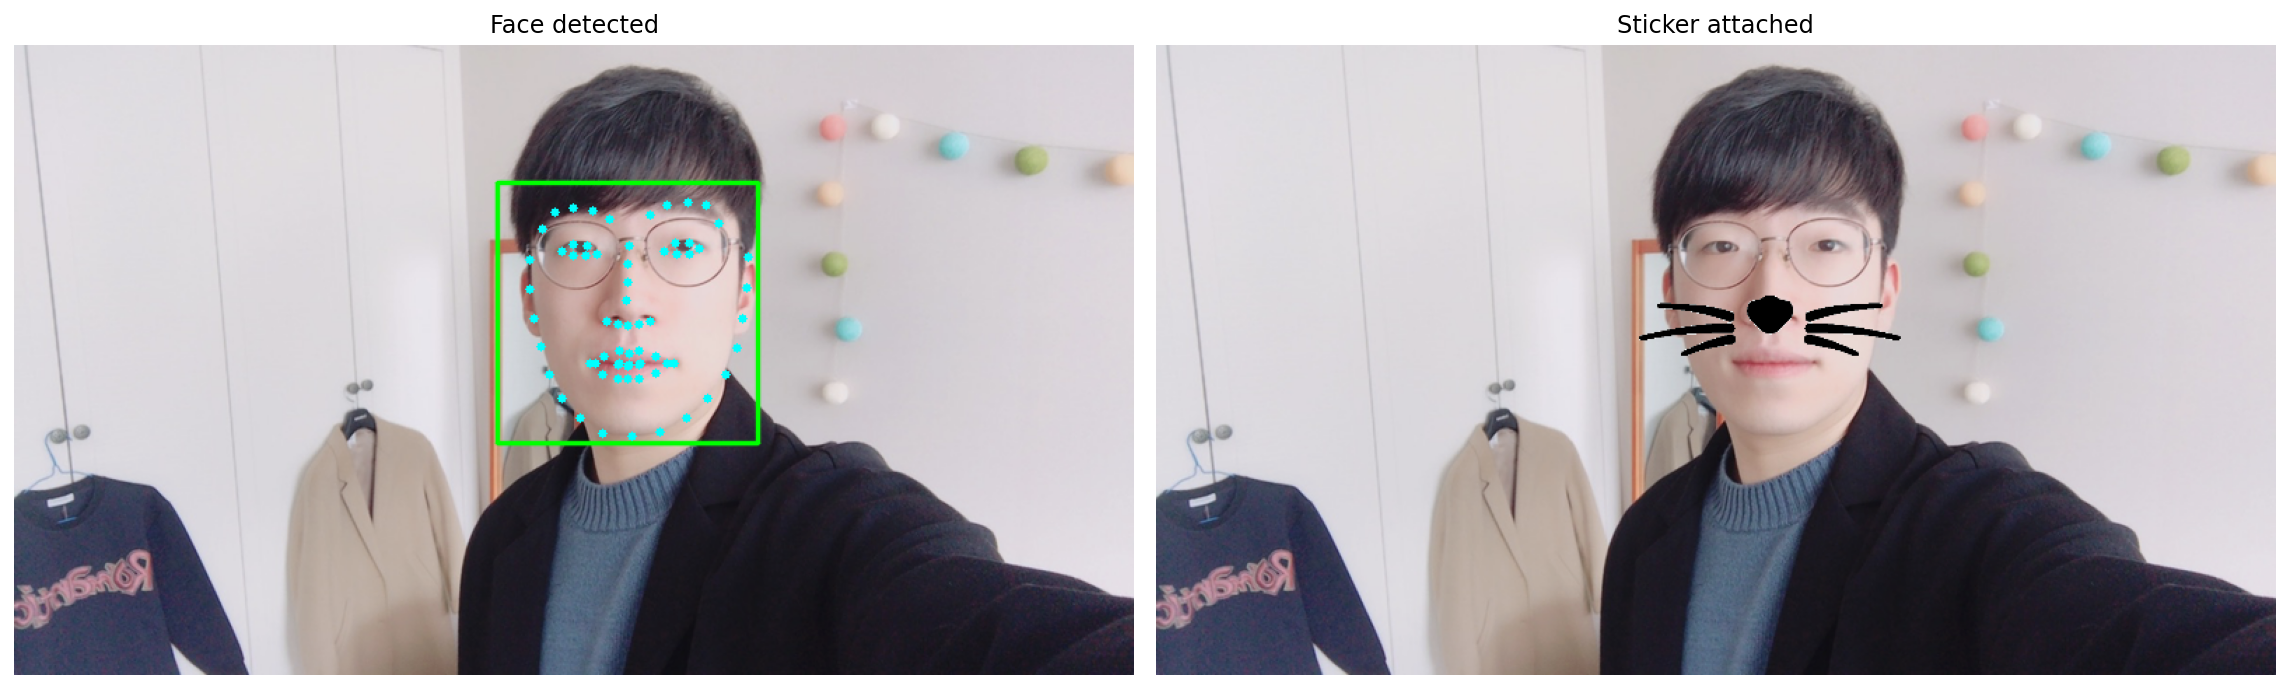

Processing image...
Total 2 faces are detected.
Total 136 feature points (68 features * 2 faces) are detected.


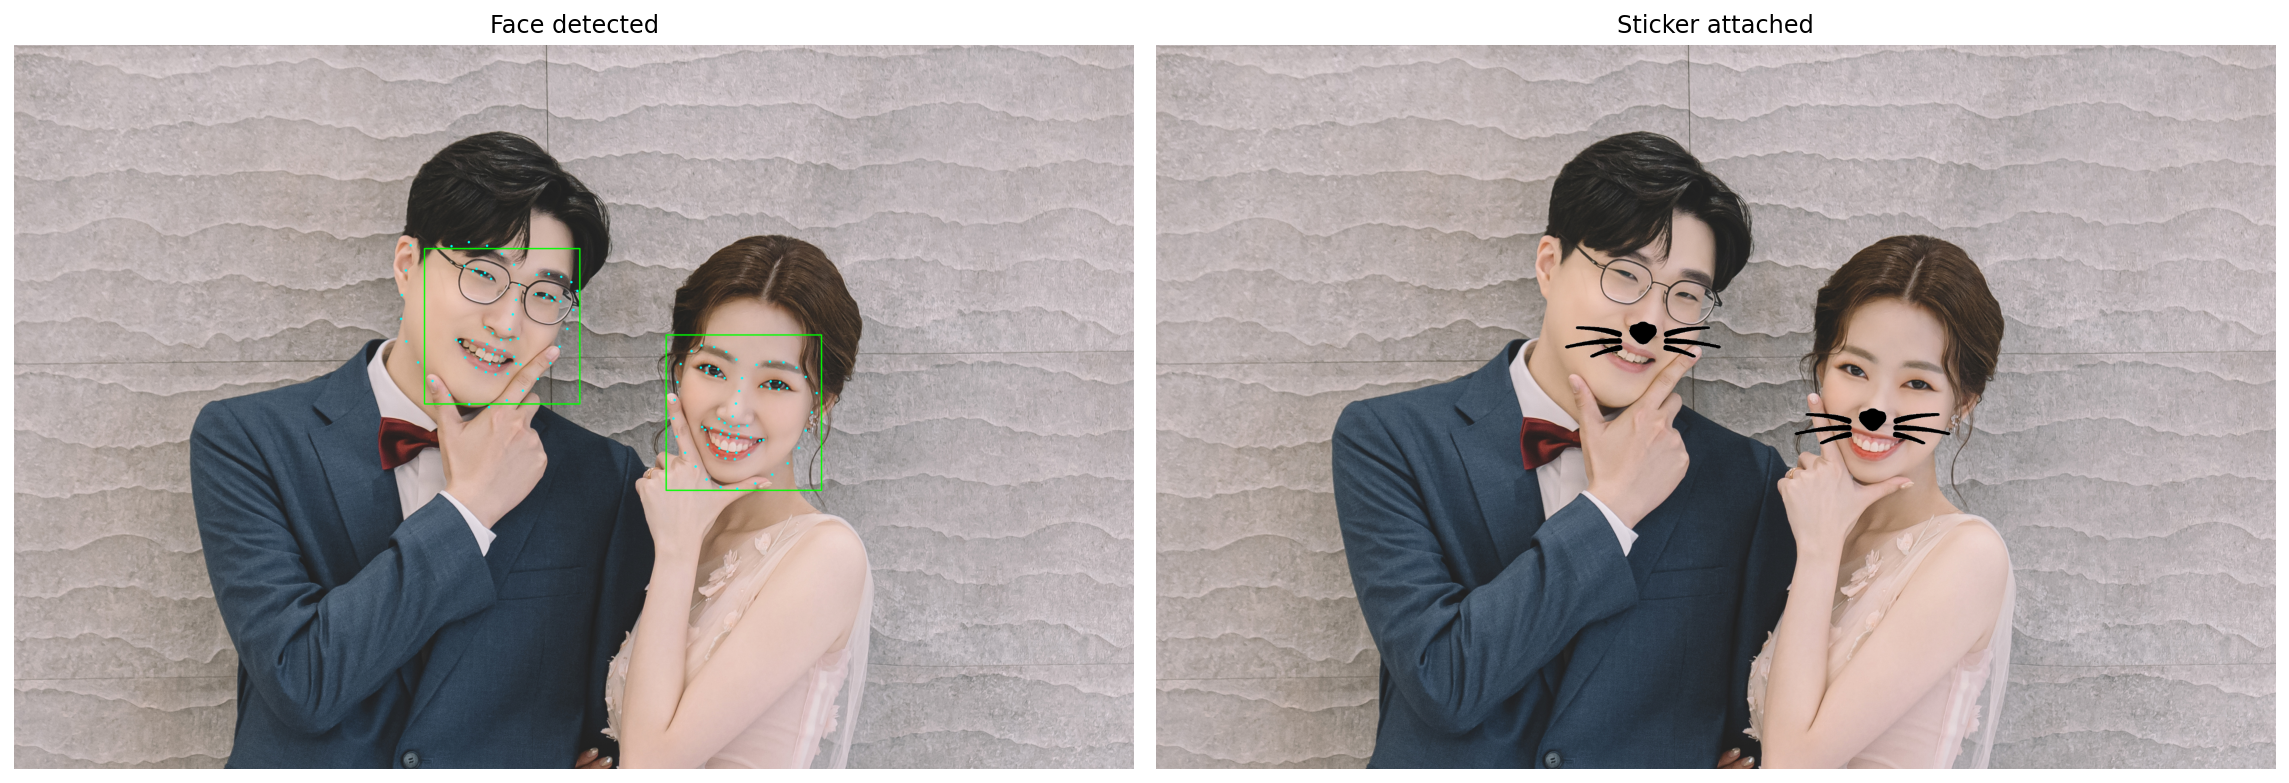

Processing image...
Total 1 faces are detected.
Total 68 feature points (68 features * 1 faces) are detected.


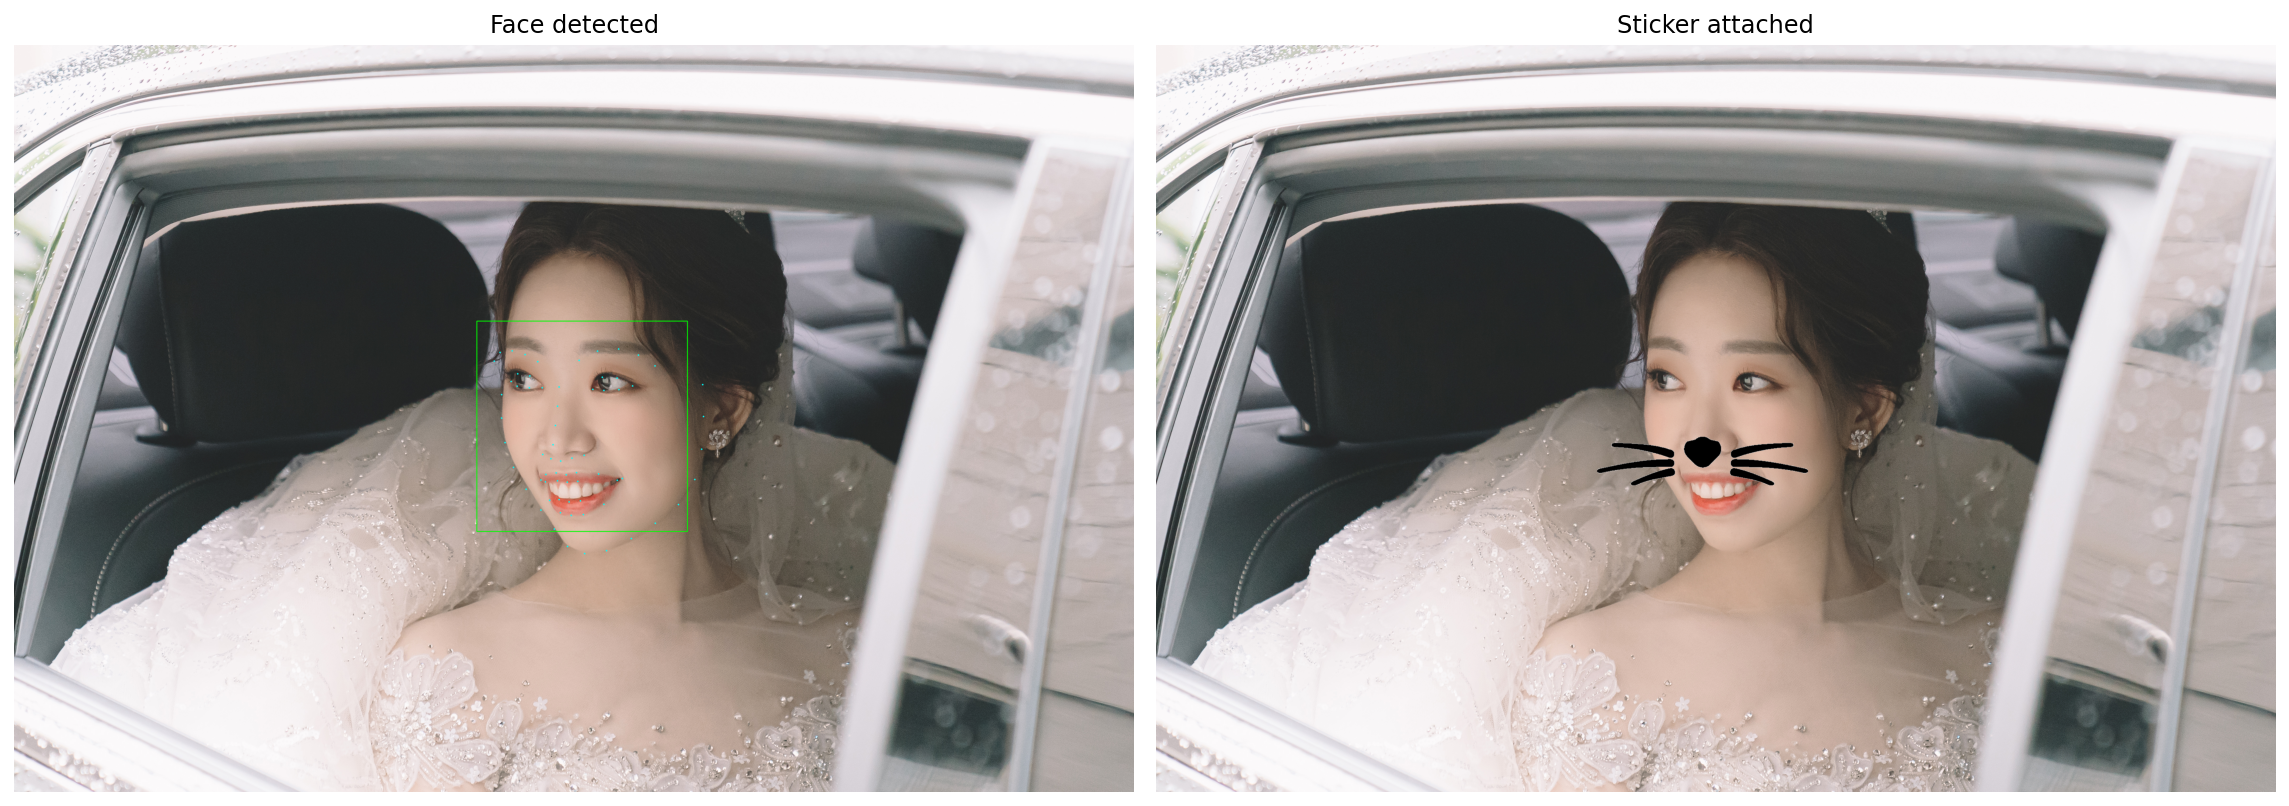

Processing image...
Total 1 faces are detected.
Total 68 feature points (68 features * 1 faces) are detected.


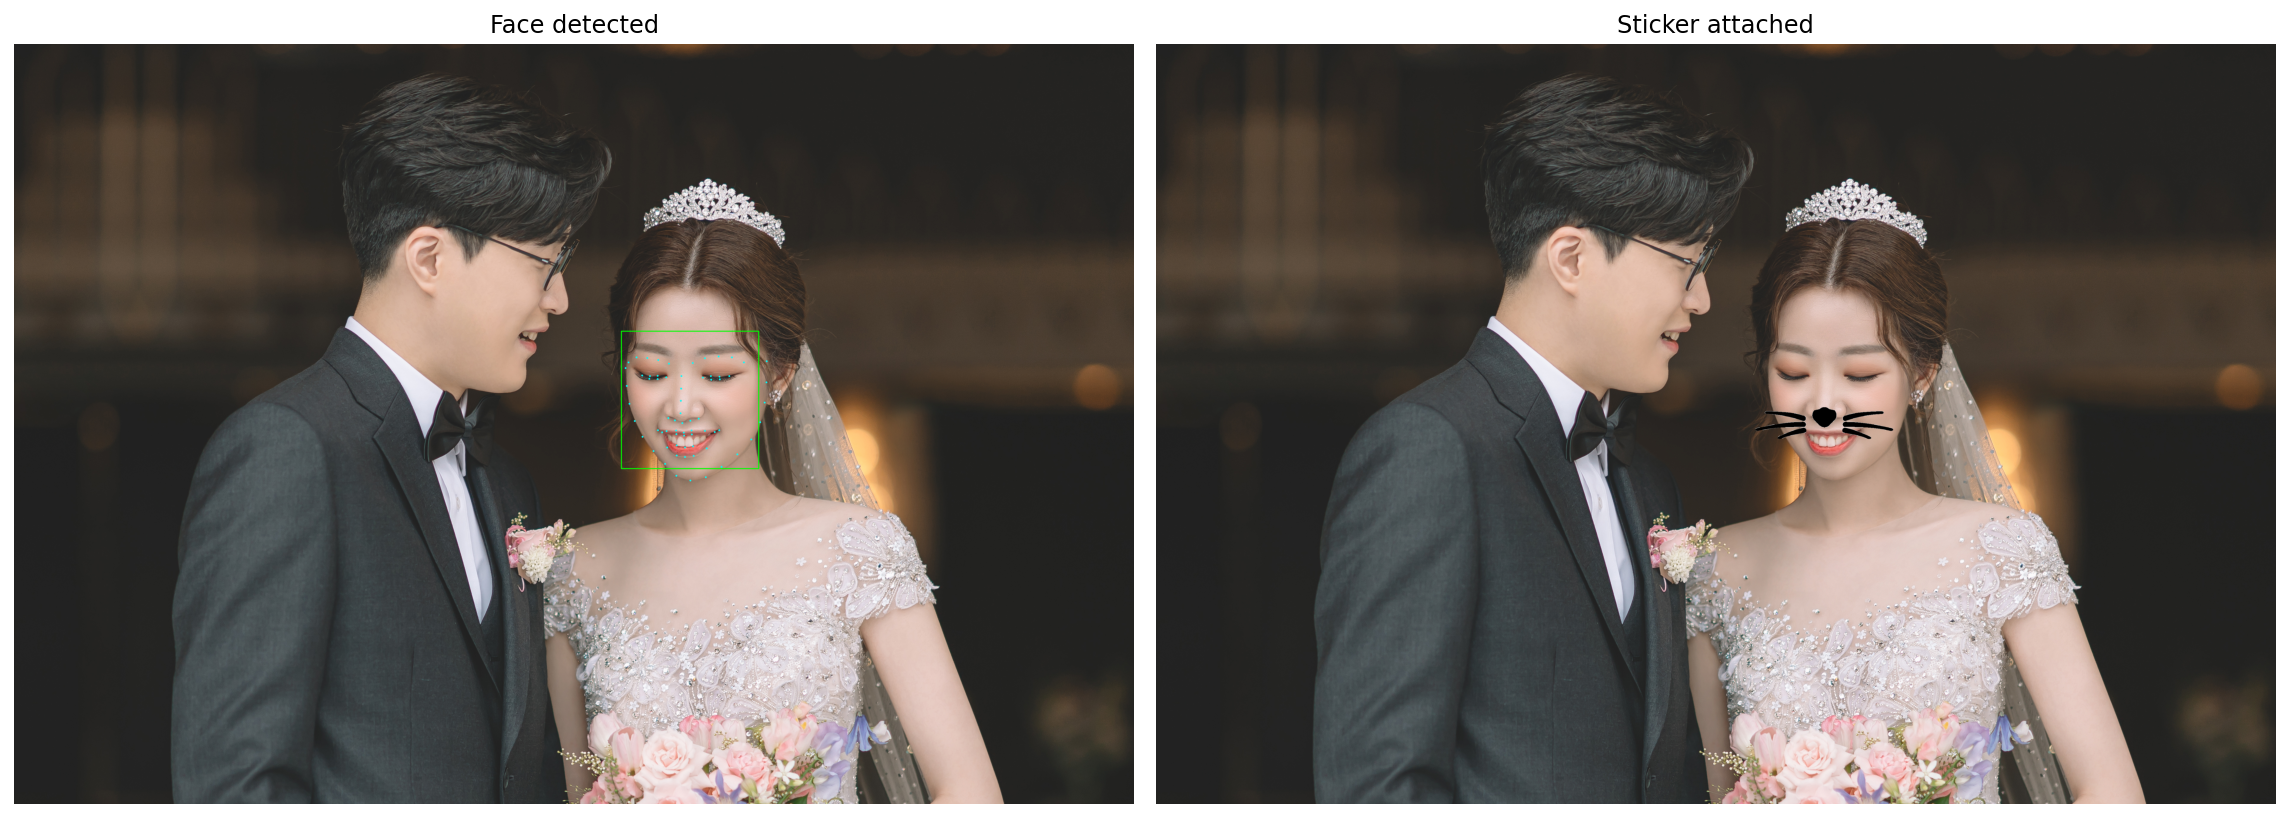

Processing image...
Total 4 faces are detected.
Total 272 feature points (68 features * 4 faces) are detected.


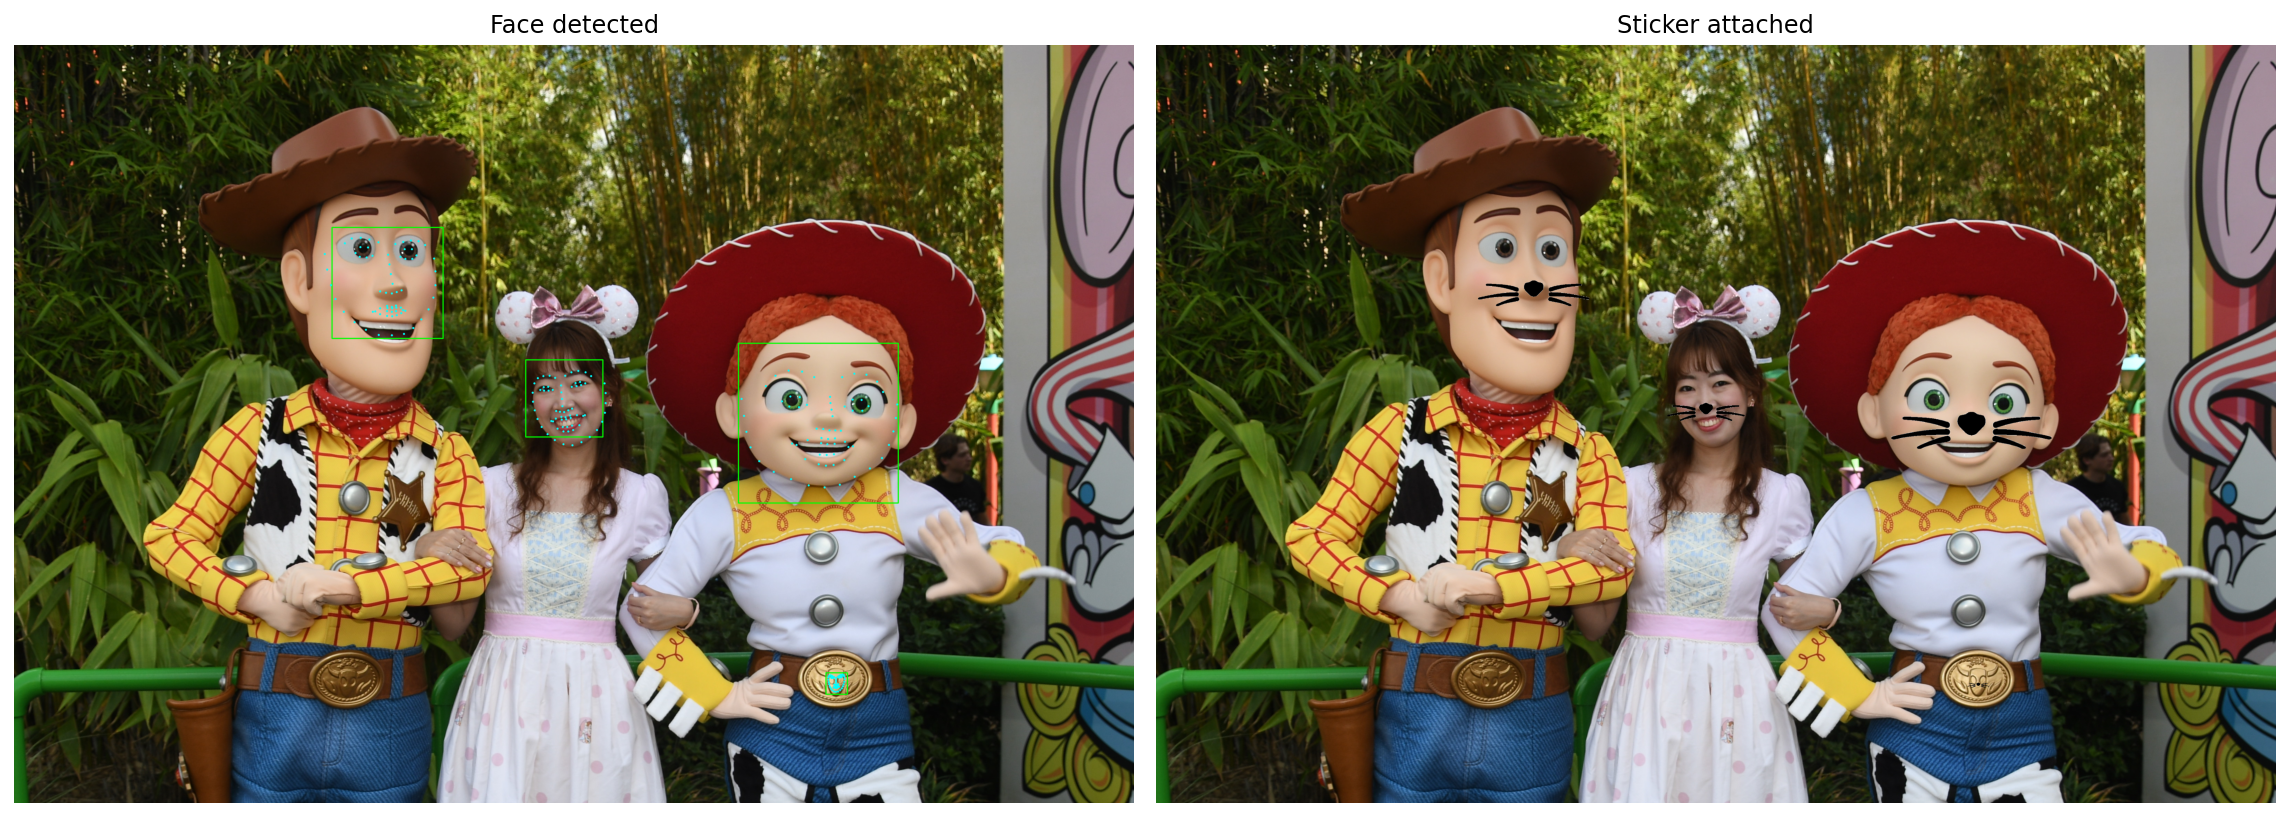

Processing image...
Total 2 faces are detected.
Total 136 feature points (68 features * 2 faces) are detected.


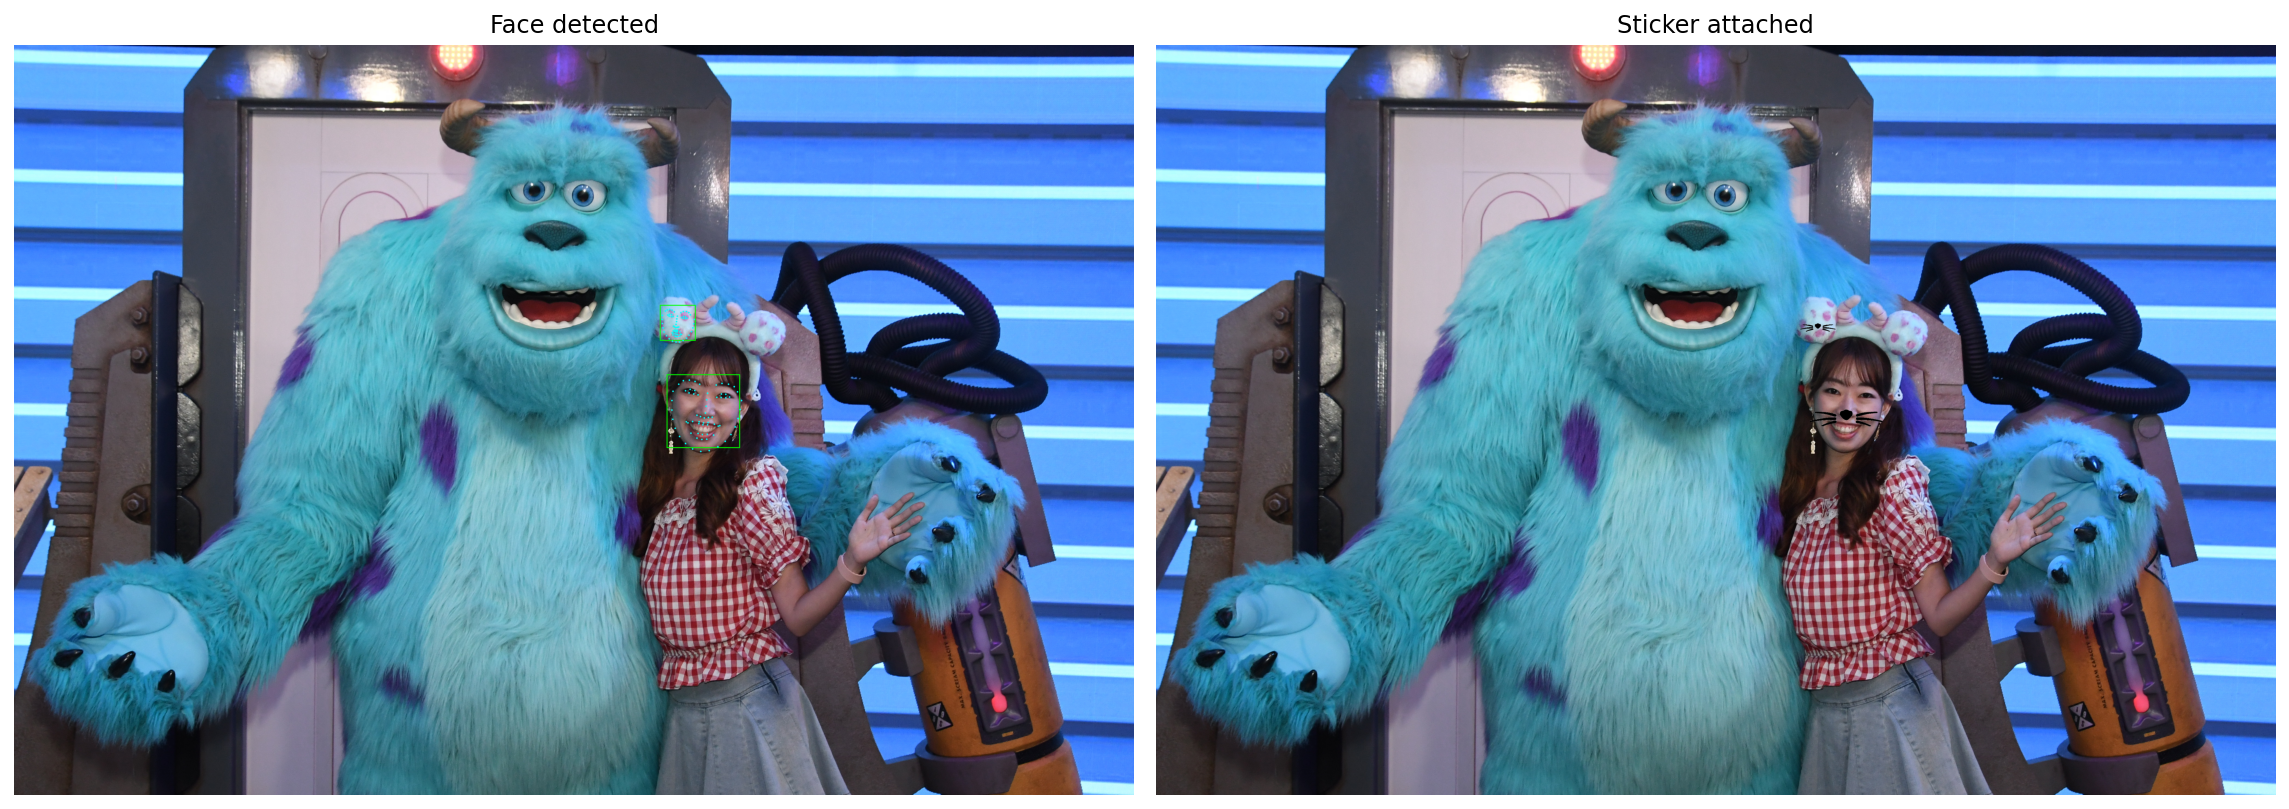

In [9]:
for img in images["rgb"]:
    print("Processing image...")
    
    # detect faces & features
    feature_detected_img, face_coords, feature_coords = detectionPipeline(img)
    # attach stickers
    sticker_attached_img = attachStickers(img, face_coords, feature_coords, CAT)
    
    # display images
    fig = plt.figure(figsize = (16, 12))
    subfig1 = fig.add_subplot(1, 2, 1)
    subfig1.imshow(feature_detected_img)
    subfig1.set_title("Face detected")
    subfig1.axis("off")

    subfig2 = fig.add_subplot(1, 2, 2)
    subfig2.imshow(sticker_attached_img)
    subfig2.set_title("Sticker attached")
    subfig2.axis("off")
    
    plt.tight_layout()
    plt.show()

### 🐱 회고록
---
귀여운 것, 꾸미는 것을 좋아하는 나에게는 최고로 즐거운 프로젝트였다 🥰💕     
다만 처음이다 보니 랜드마크(feature) 위치에 익숙하지 않아서 스티커의 위치를 조정하는 것이 조금 어려웠다.  
시간이 충분했다면, 랜드마크 간의 상대위치를 비교하여 얼굴의 기울어진 각도를 구하고, 스티커를 적절히 회전하여 붙이는 것도 가능했을 것 같다.  

<br/>

**image1.png**  
연습용 선생님 사진. 얼굴이 크고 이목구비 또한 또렷하게 잘 포착되어 얼굴감지/스티커꾸미기에 문제가 없었다.  

**image2.png**  
여러 개의 얼굴이 나오는 사진도 얼굴감지/스티커꾸미기를 정상적으로 수행할 수 있었다.  

**image3.png**  
이목구비는 또렷하니 얼굴 면적이 충분히 확보되지 않은 애매한 측면의 경우에도 얼굴감지/스티커꾸미기를 정상적으로 수행할 수 있었다.  
얼굴 감지 시 얼굴 면적은 크게 문제가 되지 않는듯 하다 (실제로 얼굴형이 뾰족한 사람도 많을테니)  

**image4.png**  
눈을 감고 있는 얼굴과 완전한 측면의 얼굴을 시험해보았다.  
눈을 감고 있는 얼굴에도 얼굴감지/스티커꾸미기를 정상적으로 수행할 수 있었다.  
(하얀 안구 + 어두운 동공)을 기준으로 눈을 감지하는 줄 알았는데 그게 아닌가 보다.  
측면 얼굴은 감지 자체를 할 수 없었는데, 아마 눈이 2개 감지되어야 얼굴로 인식되는 것 같다.  

**image5.png**  
꼭 사람이 아니더라도 이목구비 형상이 있으면 얼굴로 인식하는 것이 재미있었다 😆🎶  
심지어 제시의 벨트에 있는 얼굴 형상까지도 모두 인식되어버렸다!! 😱 (하지만 같은 모양의 우디 벨트는 어두워서인지 인식되지 않았다)   
다만 감지된 얼굴이 너무 작으면(제시 벨트) 스티커를 붙일 수 없었는데, 아마 좌표/크기 계산 과정에서 1보다 작은 소수가 정수로 변환되면서 0이 되어버린 게 아닐까 싶다.  

**image6.png**  
이번에는 이목구비는 또렷하지만 사람이 아닌 캐릭터를 실험해보았는데, 얼굴로 인식하지 못했다.  
다만 소품의 얼룩덜룩한 부분을 얼굴로 인식하였는데, 실전이였다면 제약조건을 통해 잘못 인식된 부분을 걸러내는 기능이 추가적으로 필요할 것 같다.